[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/omar-merhebi/hlc-python/blob/master/Lesson_8d_RNAseq/Lesson_8d_RNAseq_Student_Version.ipynb)

# Lesson 8d - Basic RNAseq Analysis

### Learning objectives

Work through some more advanced data manipulation and analyses, working with a normalized RNAseq matrix and it's metadata.


In [282]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind # for our t-test
from sklearn.decomposition import PCA # for our PCA

# setting an option in pandas to prevent some unnecessary warnings
pd.options.mode.chained_assignment = None 

Load the `meta_data.csv` file into a pandas data frame and store it in a variable called `metadata`.

In [293]:
# Load meta_data.csv as a pandas data frame


# Meta Data

Let's first view the metadata.

,Sample,Cell-type,Treatment
0,S1,Bcells,Control
1,S2,Bcells,Stress
2,S3,Bcells,Control
3,S4,Bcells,Stress
4,S5,Bcells,Control
5,S6,Bcells,Stress
6,S7,Bcells,Control
7,S8,Bcells,Stress
8,S9,Bcells,Control
9,S10,Bcells,Stress


Here, we have unique sample identifiers in the `Sample` column. We can see the cell types that were used in the `Cell-type` column and there were two treatments applied, a `Control` treatment and a `Stress` treatment.

Without manually counting, let's report the number of samples we have for each Cell-type and Treatment combination.
We can do this using the `.value_counts()` function on the rows of our data frame we want to summarize.

In [246]:
# use the value_counts() function to 


Cell-type  Treatment
Bcells     Control      6
           Stress       6
Tcells     Control      6
           Stress       6
dtype: int64

# Count Matrix
Now, let's load in our RNAseq count matrix as a pandas data frame and store it in a variable called `data`.

In [285]:
# load count_matrix.csv as a pandas data frame and store in a variable called data


,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,...,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24
Genes,,,,,,,,,,,,,,,,,,,,,
Trib2,8.170186,7.854769,8.041091,8.670944,8.418477,8.079618,8.108623,7.821643,8.081784,8.029107,...,9.414913,9.165448,9.174299,9.480062,9.180087,9.101975,8.986071,8.940629,8.631771,8.543056
Fam169b,8.289288,7.755767,7.263330,8.365905,8.394573,8.070281,7.820038,7.659171,8.108322,7.982075,...,9.084097,8.750208,8.852665,9.157467,9.014325,8.709465,8.804625,8.721276,8.355850,8.368229
Cd8b1,2.995732,4.204693,1.609438,4.382027,1.791759,0.693147,2.944439,3.663562,2.197225,3.332205,...,10.393049,10.166390,10.266393,10.473902,10.216252,10.013821,9.935180,9.482579,9.465370,9.208439
Cd3e,2.197225,3.583519,0.693147,0.000000,1.609438,2.708050,1.945910,1.609438,2.890372,3.044522,...,9.932706,9.763996,9.968057,10.285104,10.017352,9.682342,9.747535,9.530320,9.414994,9.354094
Fcmr,10.688393,10.254391,10.218627,10.544710,10.810152,10.377483,10.267575,9.970866,10.487712,10.428453,...,3.637586,3.610918,2.639057,1.609438,1.791759,2.708050,2.484907,0.693147,0.000000,3.135494


In this file, we have our sample identifiers along the column names and gene names along the rows.
How can we figure out how many genes we have in our data?

In [286]:
# get the shape of the data


(2999, 24)

# PCA
Let's do a PCA to summarize the variation in our samples.
We are going to use the `PCA` function from the `sklearn.decomposition` package for this analysis. From looking at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for the function, we can see that the PCA function wants data in the format samples x features. Our data is currently features x samples, so we'll have to transpose our matrix before doing the PCA.

In [287]:
# transpose the data and store in a variable called t_data


(24, 2999)

Now that our data is in the correct format, lets run the PCA, storing the results in a variable called `pca_out` and look at the output.

In [288]:
# run the PCA
pca = PCA(n_components=2) # specify the number of principal components
pca_out = pca.fit_transform(t_data) # run the analysis

pca_out

array([[-9.35579933e+01, -1.57709200e+01],
       [-8.20843773e+01, -1.47945633e+01],
       [-9.47541754e+01,  1.90172719e+01],
       [-8.88172356e+01, -2.98644534e+01],
       [-9.52767425e+01, -1.95596340e+01],
       [-8.84246011e+01, -1.50541294e+01],
       [-9.23936386e+01, -1.04201018e+00],
       [-8.56684749e+01,  2.43299679e+00],
       [-9.06247900e+01, -9.65589844e+00],
       [-8.94265508e+01, -6.97538126e-02],
       [-9.19580014e+01, -6.16559046e-01],
       [-5.25191786e+01,  1.07190702e+02],
       [ 7.97114049e+01, -6.06451117e+00],
       [ 8.40071320e+01, -2.11560535e+01],
       [ 8.78063842e+01, -2.40954320e+01],
       [ 8.26998460e+01, -7.76658044e+00],
       [ 8.89361254e+01, -7.76475423e+00],
       [ 9.57655570e+01,  3.99169360e-01],
       [ 9.39213179e+01,  3.26484157e+00],
       [ 9.06311469e+01,  7.17467492e+00],
       [ 9.04174455e+01,  7.98808906e-01],
       [ 8.65488044e+01, -2.42553144e+00],
       [ 8.22866660e+01,  2.38317586e+01],
       [ 8.

What data type did the pca give us?

numpy.ndarray

We'll want to look at the PCA results in the context of the sample metadata, so let's add the PCA results we have to the metadata.

In [302]:
metadata["PC1"] = pca_out[:, 0]
metadata["PC2"] = pca_out[:, 1]
metadata

,Sample,Cell-type,Treatment,PC1,PC2
0,S1,Bcells,Control,-93.557993,-15.770920
1,S2,Bcells,Stress,-82.084377,-14.794563
2,S3,Bcells,Control,-94.754175,19.017272
3,S4,Bcells,Stress,-88.817236,-29.864453
4,S5,Bcells,Control,-95.276742,-19.559634
5,S6,Bcells,Stress,-88.424601,-15.054129
6,S7,Bcells,Control,-92.393639,-1.042010
7,S8,Bcells,Stress,-85.668475,2.432997
8,S9,Bcells,Control,-90.624790,-9.655898
9,S10,Bcells,Stress,-89.426551,-0.069754


Now, let's plot the PCA! We can use a scatter plot for this and let's use different colors and marker types to distinguish between the samples.

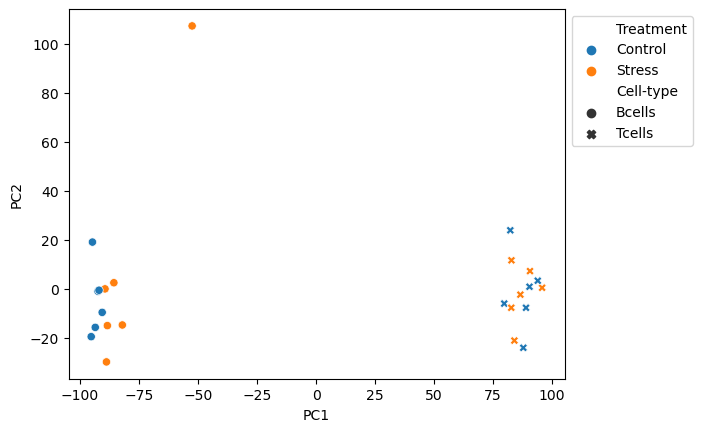

In [304]:
# plot the PCA results, coloring by Treatment and styling the points by Cell-type
ax = sns.scatterplot(x="PC1", y="PC2", data=metadata, style="Cell-type", hue="Treatment")

# move the legend outside the plot area so we can see the data more clearly
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

It looks like one of our data points is separating pretty far away from the others on the PCA. Let's label the points to figure out which one it is.

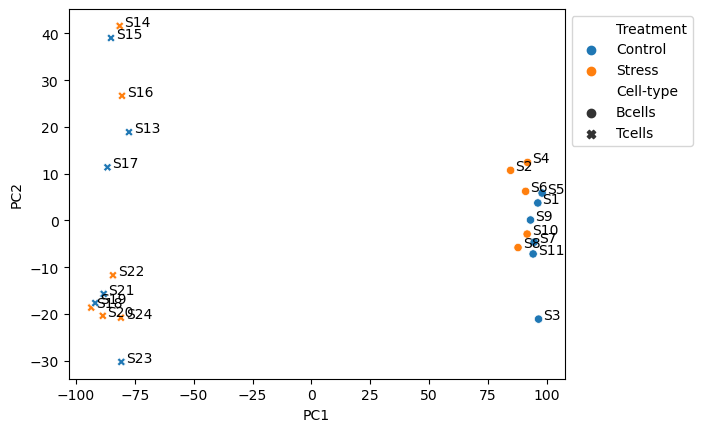

In [338]:
# Color the PCA by sample number to figure out which sample it is
ax = sns.scatterplot(x="PC1", y="PC2", data=metadata, style="Cell-type", hue="Treatment")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Add labels to the pca points
for i in range(metadata.shape[0]):
    line = metadata.iloc[i, :]
    ax.text(line['PC1']+2, line['PC2'], str(line['Sample'])) 
    # the +2 above adjusts the x coord of the number label so it's not directly on the point

Let's say we talk to the person who ran the experiment and find out that there were significant issues with prepping that sample and we decide to exclude it from our analyses.

In [306]:
# Exclude sample 12 from the data and metadata
data = data.drop(["S12"], axis=1)
metadata = metadata[metadata['Sample'] != "S12"]=

Now, that we've excluded our outlier, let's rerun our PCA.

In [316]:
# Copy the code from above to recalculate the PCA
pca = PCA(n_components=3) # specify the number of principal components
pca_out = pca.fit_transform(data.transpose()) # run the analysis

# Replace the PC1 and PC2 columns with our new analysis results
metadata["PC1"] = pca_out[:, 0]
metadata["PC2"] = pca_out[:, 1]

metadata

,Sample,Cell-type,Treatment,PC1,PC2,PC3
0,S1,Bcells,Control,96.114877,3.749899,-12.830418
1,S2,Bcells,Stress,84.563696,10.720745,-9.884694
2,S3,Bcells,Control,96.430728,-21.081962,42.751056
3,S4,Bcells,Stress,91.760429,12.410542,-29.407401
4,S5,Bcells,Control,97.933043,5.867125,-17.475332
5,S6,Bcells,Stress,90.941305,6.229415,-10.611097
6,S7,Bcells,Control,94.557722,-4.629490,7.772700
7,S8,Bcells,Stress,87.712346,-5.784726,5.778849
8,S9,Bcells,Control,93.005769,0.104852,-8.210324
9,S10,Bcells,Stress,91.578001,-2.897881,22.938859


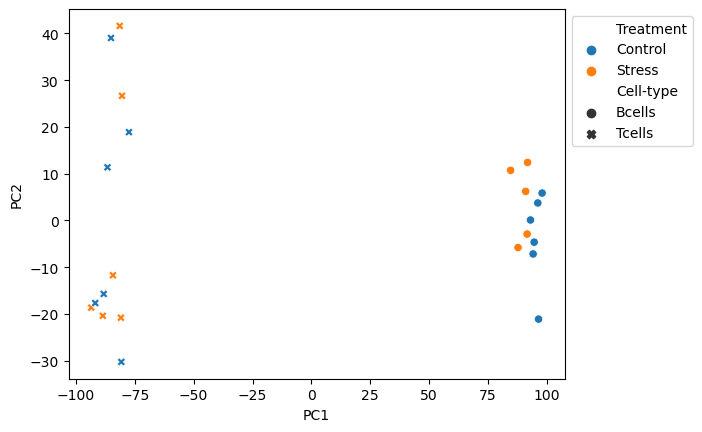

In [317]:
ax = sns.scatterplot(x="PC1", y="PC2", data=metadata, style="Cell-type", hue="Treatment")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Calculate Statistics
For the rest of our analysis, let's just look at the Bcells. Subset the data and metadata to just the Bcells. Store the subsetted dataframes in objects called `bcell_data` and `bcell_metadata`.

In [320]:
# subset metadata to only Bcells
bcell_metadata = metadata[metadata["Cell-type"] == "Bcells"]
# subset data to only Bcell samples
bcell_data = data[bcell_metadata["Sample"]]

Next, let's extract the sample ids for each treatment since that's the id that our data matrix uses.

In [259]:
# get the names of the samples in each treatment
control_samples = bcell_metadata[bcell_metadata["Treatment"] == "Control"]["Sample"]
stress_samples = bcell_metadata[bcell_metadata["Treatment"] == "Stress"]["Sample"]

Now we can use the sample ids we just extracted to isolate the data for each treatment and calculate the log2 fold change. Log2 Fold change can be calculated per gene like:
    log2( mean(treatment_data) / mean(control_data) )

In [328]:
# calculate log2 fold change between control and stress
log2fc = np.log2( np.mean(bcell_data[stress_samples], axis=1) / np.mean(bcell_data[control_samples], axis=1) )

/Users/gracekenney/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [329]:
bcell_data["log2FC"] = log2fc
bcell_data.head()

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,log2FC
Genes,,,,,,,,,,,,
Trib2,8.170186,7.854769,8.041091,8.670944,8.418477,8.079618,8.108623,7.821643,8.081784,8.029107,8.074649,-0.010290
Fam169b,8.289288,7.755767,7.263330,8.365905,8.394573,8.070281,7.820038,7.659171,8.108322,7.982075,7.834392,0.002716
Cd8b1,2.995732,4.204693,1.609438,4.382027,1.791759,0.693147,2.944439,3.663562,2.197225,3.332205,1.386294,0.595596
Cd3e,2.197225,3.583519,0.693147,0.000000,1.609438,2.708050,1.945910,1.609438,2.890372,3.044522,1.098612,0.331986
Fcmr,10.688393,10.254391,10.218627,10.544710,10.810152,10.377483,10.267575,9.970866,10.487712,10.428453,10.452042,-0.023890


How many genes have a log2FC > 1 in our comparison?

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,log2FC
Genes,,,,,,,,,,,,
Ptpro,0.000000,3.583519,0.000000,0.000000,0.693147,3.496508,1.098612,0.693147,3.044522,1.791759,0.693147,1.053659
Rit1,0.000000,3.637586,0.000000,3.044522,1.791759,2.079442,0.693147,1.098612,0.000000,1.609438,1.386294,1.829996
Pla2g7,1.386294,3.663562,3.970292,3.433987,0.000000,2.944439,0.693147,2.079442,2.197225,2.890372,0.000000,1.127198
Pilra,2.708050,3.663562,0.693147,2.197225,0.000000,0.000000,0.693147,3.663562,2.079442,3.970292,0.693147,1.237683
Cd300lb,1.791759,3.806662,1.098612,0.000000,1.945910,2.302585,0.693147,0.693147,0.000000,3.970292,0.000000,1.225210
...,...,...,...,...,...,...,...,...,...,...,...,...
Mfsd2a,0.000000,0.000000,0.693147,0.000000,0.000000,2.772589,0.000000,0.000000,0.693147,0.000000,0.000000,1.263034
Ccdc141,0.000000,0.000000,0.000000,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,3.295837,0.000000,inf
AU040972,2.708050,0.000000,0.000000,0.000000,0.693147,2.708050,0.000000,2.708050,0.000000,2.079442,0.000000,1.403024


How many genes have a log2FC < -1 in our comparison?

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,log2FC
Genes,,,,,,,,,,,,
Serpinb10,1.945910,1.609438,1.791759,2.197225,1.791759,1.098612,3.178054,0.000000,0.000000,0.000000,3.433987,-1.044503
Cd6,3.044522,0.693147,0.000000,0.000000,3.044522,0.000000,4.143135,1.098612,0.693147,0.693147,1.098612,-2.011612
Clec4a3,1.609438,0.693147,0.693147,1.386294,2.708050,2.079442,4.007333,0.000000,1.098612,0.000000,3.555348,-1.453914
Skint3,0.693147,0.693147,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,1.386294,0.000000,0.000000,-1.933876
Tdrp,2.197225,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,1.791759,1.945910,-1.169487
...,...,...,...,...,...,...,...,...,...,...,...,...
Gm38158,2.564949,2.708050,1.609438,1.098612,3.091042,1.098612,0.693147,0.000000,2.890372,0.000000,3.044522,-1.238967
Spint1,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-inf
Cyp17a1,2.944439,0.000000,0.000000,1.386294,2.397895,0.000000,0.000000,0.000000,2.772589,0.000000,0.693147,-2.404558


Lastly, let's test if the difference in the means between our two treatments is significant with a t-test.

In [339]:
# initialize columns for pvalues
bcell_data["pval"] = None
bcell_data["neg_log10_pval"] = None

# loop through each gene
for gene in bcell_data.index:
    # get the expression data for each condition for the current gene
    stress_gene_data = bcell_data[stress_samples].loc[gene,:]
    control_gene_data = bcell_data[control_samples].loc[gene,:]

    # run a t-test and extract the p-value
    pval = ttest_ind(stress_gene_data, control_gene_data).pvalue
    
    # store the p-value in the pval column for that gene
    bcell_data.loc[gene,"pval"] = pval
    # calculate the -log10(pvalue) and store in the neg_log10_pval column
    bcell_data.loc[gene,"neg_log10_pval"] = -np.log10(pval)
    
bcell_data.head()

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,log2FC,pval,neg_log10_pval,significant
Genes,,,,,,,,,,,,,,,
Trib2,8.170186,7.854769,8.041091,8.670944,8.418477,8.079618,8.108623,7.821643,8.081784,8.029107,8.074649,-0.010290,0.711512,0.147818,False
Fam169b,8.289288,7.755767,7.263330,8.365905,8.394573,8.070281,7.820038,7.659171,8.108322,7.982075,7.834392,0.002716,0.946305,0.023969,False
Cd8b1,2.995732,4.204693,1.609438,4.382027,1.791759,0.693147,2.944439,3.663562,2.197225,3.332205,1.386294,0.595596,0.138501,0.858548,False
Cd3e,2.197225,3.583519,0.693147,0.000000,1.609438,2.708050,1.945910,1.609438,2.890372,3.044522,1.098612,0.331986,0.521521,0.282728,False
Fcmr,10.688393,10.254391,10.218627,10.544710,10.810152,10.377483,10.267575,9.970866,10.487712,10.428453,10.452042,-0.023890,0.239063,0.621487,False


A common way to visualize this type of data is with a volcano plot, where Log2 fold change is on the x-axis and -Log10(pvalue) is on the y-axis. Let's use a scatter plot to make this.

<AxesSubplot: xlabel='log2FC', ylabel='neg_log10_pval'>

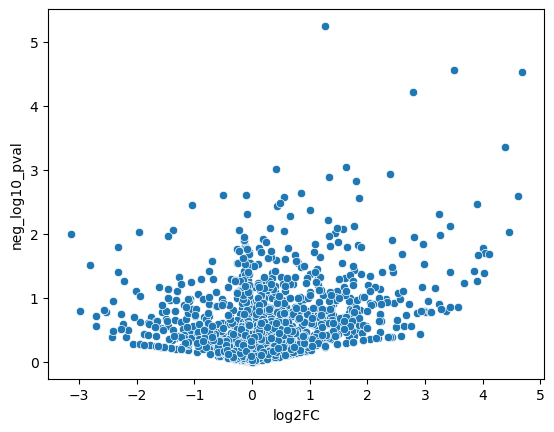

In [340]:
ax = sns.scatterplot(x="log2FC", y="neg_log10_pval", data=bcell_data)
ax

It'd be helpful if we could highlight which genes pass certain log2 fold change and/or pvalue thresholds. Let's build a logical statement to test if each gene is "significant" (in this case, has a log2FC > 1 OR a log2FC < 1 AND a pvalue < 0.05). 
Let's store the result in a column called "significant" in our bcell_data data frame so we can use it for plotting.

In [341]:
# conditional statement that returns T/F if gene passes thresholds


Let's make the same volcano plot, now coloring by significance.

<AxesSubplot: title={'center': 'Differentially Expressed Genes Between\n Stress and Control in Bcells'}, xlabel='Log2FC', ylabel='-Log10(pval)'>

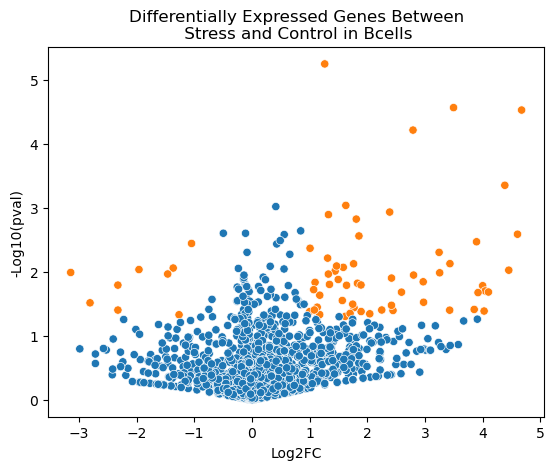

In [342]:
ax = sns.scatterplot(x="log2FC", y="neg_log10_pval", data=bcell_data, hue="significant", legend=False)
ax.set(xlabel='Log2FC', ylabel='-Log10(pval)', title='Differentially Expressed Genes Between\n Stress and Control in Bcells')

ax